<a href="https://colab.research.google.com/github/Oooscar8/UBC-CPEN355-Machine-Learning/blob/main/Ticket_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('ticket_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14701 entries, 0 to 14700
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Event Name             14701 non-null  object 
 1   Locale                 14701 non-null  object 
 2   Minimum Price          12376 non-null  float64
 3   Maximum Price          12376 non-null  float64
 4   Currency               12479 non-null  object 
 5   Start Date             14701 non-null  object 
 6   Start Time             14339 non-null  object 
 7   Timezone               13742 non-null  object 
 8   Sales Start            14664 non-null  object 
 9   Sales End              14664 non-null  object 
 10  Genre                  14691 non-null  object 
 11  Promoter Name          11108 non-null  object 
 12  Venue Name             14490 non-null  object 
 13  Venue City             14695 non-null  object 
 14  Venue State            11604 non-null  object 
 15  Ve

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [11]:
class CombineGenresTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        if self.columns is None and isinstance(X, pd.DataFrame):
            self.columns = X.columns
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns)
        return X.apply(lambda row: row.dropna().tolist(), axis=1)


In [12]:
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [13]:
numeric_columns = ['Popularity', 'Followers', 'City Population', 'Hour_sin', 'Month_sin', 'Sales Duration (days)']
categorical_columns = ['Promoter Name', 'Venue City', 'Venue State', 'Venue Country', 'Condensed Venue Name', 'Is_Weekend']
genre_columns = ['Condensed Genre', 'Condensed Genre1', 'Condensed Genre2', 'Condensed Genre3']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

genre_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('combine', CombineGenresTransformer(columns = genre_columns)),
    ('onehot', MultiLabelBinarizerTransformer())
])

In [14]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('genre', genre_transformer, genre_columns)
    ])

In [15]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

df.dropna(subset=['Minimum Price USD'], inplace=True)

X = df.drop(columns=['Minimum Price USD'])
y = df['Minimum Price USD']

scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=5)

print("Cross-Validation MAE Scores:", -scores)
print("Mean MAE:", -scores.mean())


Cross-Validation MAE Scores: [34.69650313 31.80291343 36.43875012 31.3646796  31.61452417]
Mean MAE: 33.183474091051785


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

df.dropna(subset=['Minimum Price USD'], inplace=True)

X = df.drop(columns=['Minimum Price USD'])
y = df['Minimum Price USD']

scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=5)

print("Cross-Validation MAE Scores:", -scores)
print("Mean MAE:", -scores.mean())

Cross-Validation MAE Scores: [24.09981727 23.97360928 27.07051613 23.46720919 22.65534044]
Mean MAE: 24.253298464015273


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def analyze_price_segments(df):
    """
    Analysis of price segments
    """
    plt.figure(figsize=(20, 12))

    # Artist Popularity Across Price Segments using violin plot
    plt.subplot(2, 2, 1)
    sns.violinplot(data=df, x='price_segment', y='Popularity', hue='price_segment',
                  legend=False, cut=0)  # cut=0 limits the violin range to data
    plt.title('Artist Popularity Across Price Segments', fontsize=12, pad=15)
    plt.xlabel('Price Segment', fontsize=10)
    plt.ylabel('Artist Popularity', fontsize=10)

    # Genre Distribution
    plt.figure(figsize=(12, 6))
    genre_segment = pd.crosstab(df['price_segment'], df['Condensed Genre'], normalize='index') * 100
    genre_segment.plot(kind='bar', stacked=True, colormap='tab20')
    plt.title('Genre Distribution by Price Segment (%)', fontsize=12, pad=15)
    plt.xlabel('Price Segment', fontsize=10)
    plt.ylabel('Percentage', fontsize=10)
    # Move legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1),
              loc='upper left',
              title='Genre',
              borderaxespad=0.)
    plt.tight_layout()


def analyze_price_distributions(df):
    """
    Analysis of price distributions
    """
    # Price Distributions
    plt.figure(figsize=(15, 5))

    # Weekend vs Weekday plot
    plt.subplot(1, 2, 1)
    price_clip = df['Minimum Price USD'].quantile(0.95)
    df_clipped = df.copy()
    df_clipped['Minimum Price USD'] = df_clipped['Minimum Price USD'].clip(upper=price_clip)
    sns.violinplot(data=df_clipped,
                  x='Is_Weekend',
                  y='Minimum Price USD',
                  hue='Is_Weekend',
                  legend=False,
                  inner='box',
                  cut=0)
    plt.title('Price Distribution: Weekend vs Weekday\n(95th percentile)',
             fontsize=12, pad=15)
    plt.xlabel('Weekend (1) vs Weekday (0)', fontsize=10)
    plt.ylabel('Price (USD)', fontsize=10)

    # Country comparison
    plt.subplot(1, 2, 2)
    top_countries = df['Venue Country'].value_counts().nlargest(5).index
    country_data = df_clipped[df_clipped['Venue Country'].isin(top_countries)]
    sns.violinplot(data=country_data,
                  x='Venue Country',
                  y='Minimum Price USD',
                  hue='Venue Country',
                  legend=False,
                  cut=0)
    plt.title('Price Distribution by Top 5 Countries\n(95th percentile)',
             fontsize=12, pad=15)
    plt.xlabel('Country', fontsize=10)
    plt.ylabel('Price (USD)', fontsize=10)
    plt.xticks(rotation=45)

    plt.tight_layout()

def analyze_additional_patterns(df):
    plt.figure(figsize=(15, 10))

    # Price distribution by weekday with event count
    plt.subplot(2, 2, 1)
    # Add event count on secondary axis
    weekday_prices = df.groupby('Weekday')['Minimum Price USD'].mean()
    weekday_counts = df['Weekday'].value_counts().sort_index()

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    sns.barplot(x=weekday_prices.index, y=weekday_prices.values, alpha=0.5, ax=ax1)
    ax1.set_ylabel('Average Price (USD)', color='b')

    ax2.plot(weekday_counts.index, weekday_counts.values, 'r-')
    ax2.set_ylabel('Number of Events', color='r')

    plt.title('Average Price and Event Count by Day of Week')

    # Top 10 cities by average price
    plt.subplot(2, 2, 2)
    city_metrics = df.groupby('Venue City').agg({
        'Minimum Price USD': 'mean',
        'Venue City': 'count'
    }).rename(columns={'Venue City': 'Event Count'})

    # Filter cities with significant number of events
    min_events = df['Venue City'].value_counts().median()  # Use median as threshold
    significant_cities = city_metrics[city_metrics['Event Count'] >= min_events]
    top_cities = significant_cities.nlargest(10, 'Minimum Price USD')

    sns.barplot(x=top_cities['Minimum Price USD'], y=top_cities.index)
    plt.title('Top 10 Cities by Average Price\n(Cities with significant number of events)')

    plt.tight_layout()

# Function to run all analyses
def run_eda(df):
    """
    Run all EDA analyses
    """
    # Create price segments if not already present
    df['price_segment'] = pd.qcut(df['Minimum Price USD'],
                                q=4,
                                labels=['Budget', 'Economy', 'Standard', 'Premium'])

    analyze_price_segments(df)
    analyze_price_distributions(df)
    analyze_additional_patterns(df)

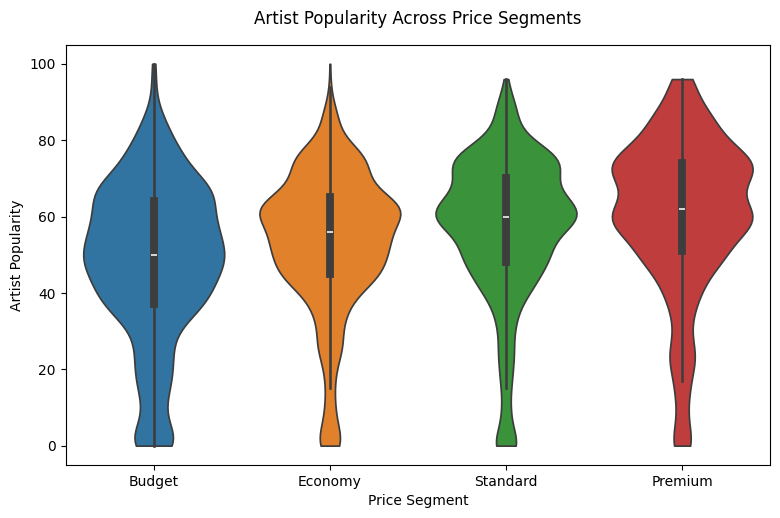

<Figure size 1200x600 with 0 Axes>

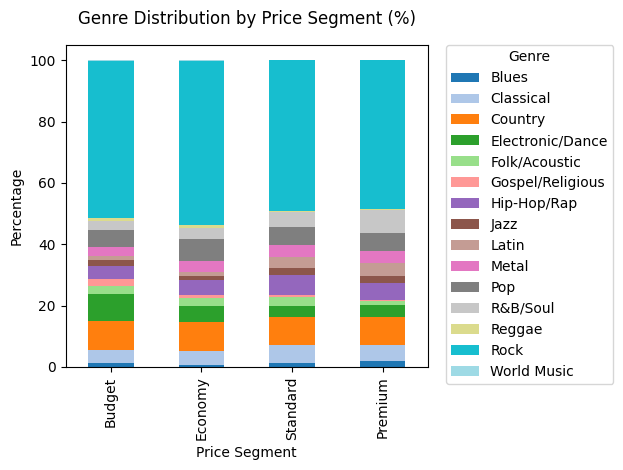

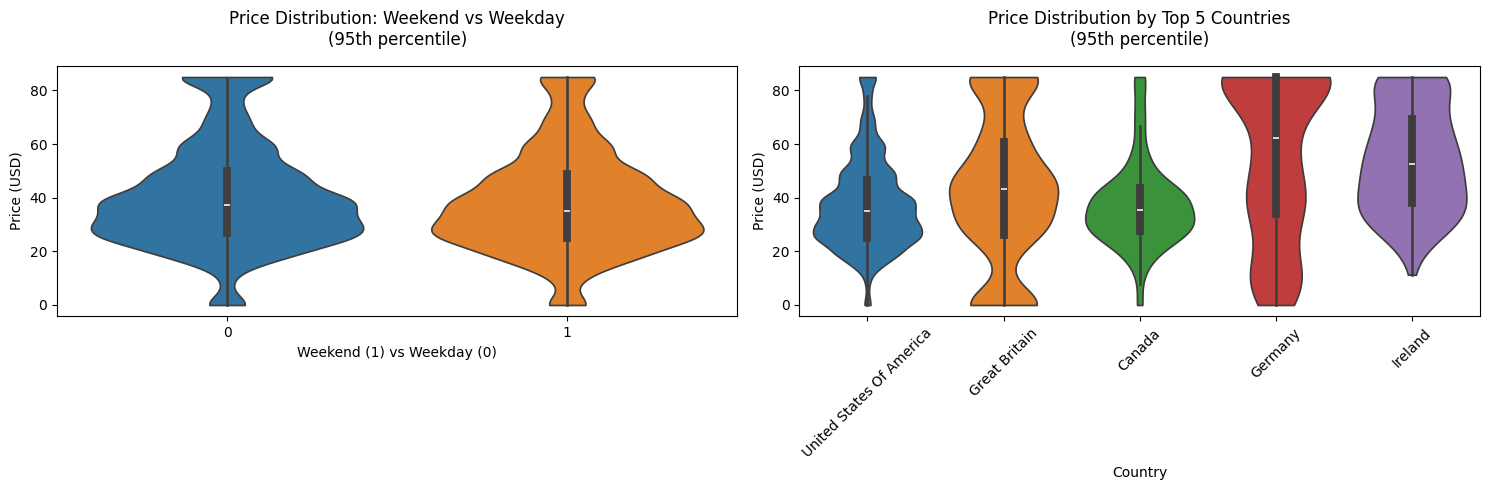

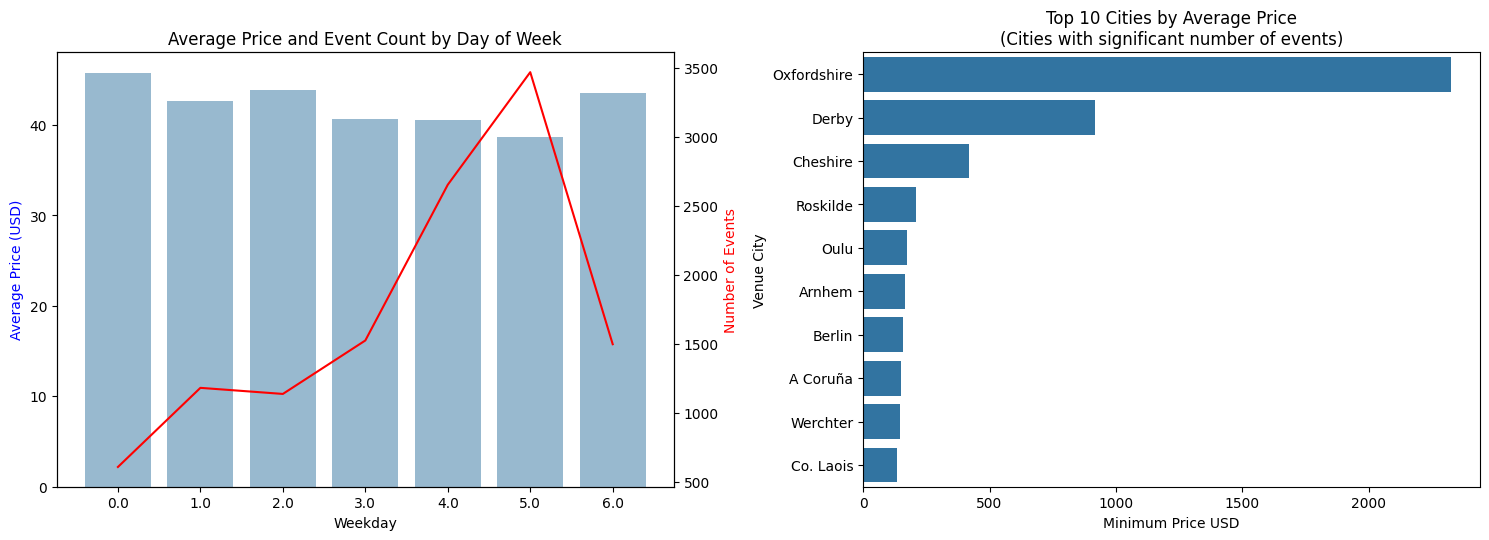

In [21]:
run_eda(df)